In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../') # add the root folder to the path

from diffusion_model.backward_module import BackwardModule
from diffusion_model.forward_module import ForwardModule
from diffusion_model.embeddings import MLPEmbedding, LinearEmbedding
from diffusion_model.scheduler import Scheduler
from diffusion_model.models import UNetNoiseModel
from diffusion_model.datasets import get_mnist_dataset
from diffusion_model.constants import device

import numpy as np
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

from einops import rearrange

import matplotlib.pyplot as plt
import matplotlib

In [3]:
FIG_SIZE = 4
matplotlib.rcParams['figure.figsize'] = (FIG_SIZE, FIG_SIZE)

# Datasets

Dataset shape: torch.Size([1000, 28, 28])


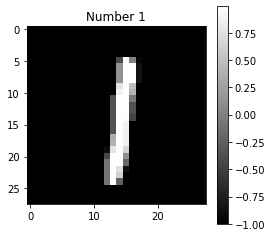

In [76]:
N_SAMPLES = 1000

dataset, labels = get_mnist_dataset(N_SAMPLES)
dim = tuple(dataset[0].shape)
flattened_dim = np.prod(dim)

plt.imshow(dataset[0].cpu(), cmap="gray")
plt.title(f"Number {labels[0]}")
plt.colorbar();
print(f"Dataset shape: {dataset.shape}")

In [5]:
print(f"Using device: {device}")

Using device: cuda


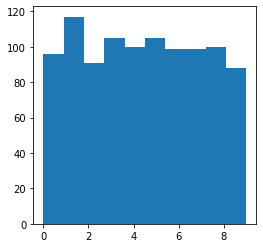

In [6]:
plt.hist(labels.cpu(), bins=10);

# Plot helpers

In [7]:
def plot_evolutions(xs_t, y_title=None, title=None):
    fig, axes = plt.subplots(1, len(xs_t), figsize=(FIG_SIZE*len(xs_t), FIG_SIZE))
    if title is not None:
        fig.suptitle(title)
    if y_title is not None:
        axes[0].set_ylabel(y_title)
    for i, ax in enumerate(axes):
        progress = i / (len(xs_t)-1)
        ax.imshow(xs_t[i].cpu(), cmap='gray')
        ax.set_title(f"t={progress*100:.0f}%")
    plt.show()

# Embeddings

In [8]:
def check_embedding(base, embedding_model):
    with torch.no_grad():
        base = base.to(device)
        embedded_base = embedding_model(base).detach().cpu()
    for v in embedded_base:
        assert ((-1 <= v) & (v <= 1)).all(), "Embedding should be in [-1, 1]"

    n = len(base)
    dist_matrix = torch.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = torch.norm(embedded_base[i] - embedded_base[j])
    plt.title("Distance matrix")
    plt.imshow(dist_matrix, cmap='gray')
    plt.colorbar()

# Diffusion model

## Scheduler

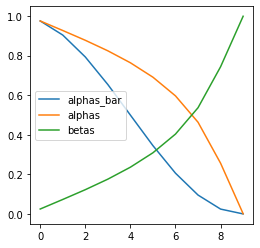

In [77]:
T = 10

scheduler = Scheduler(input_dim=dim, nb_steps=T, schedule_type="cosine")

plt.plot(scheduler.alphas_bar.cpu()[:, 0, 0], label="alphas_bar")
plt.plot(scheduler.alphas.cpu()[:, 0, 0], label="alphas")
plt.plot(scheduler.betas.cpu()[:, 0, 0], label="betas")
plt.legend();

In [13]:
print(f"beta: min={scheduler.betas.min().item()}, max={scheduler.betas.max().item()}")

beta: min=0.024820685386657715, max=0.9990000128746033


## Modules and model

In [70]:
forward_module = ForwardModule(scheduler=scheduler)
noise_model = UNetNoiseModel(forward_module=forward_module, scheduler=scheduler)
backward_module = BackwardModule(forward_module=forward_module, scheduler=scheduler, noise_model=noise_model)

V18


## Forward

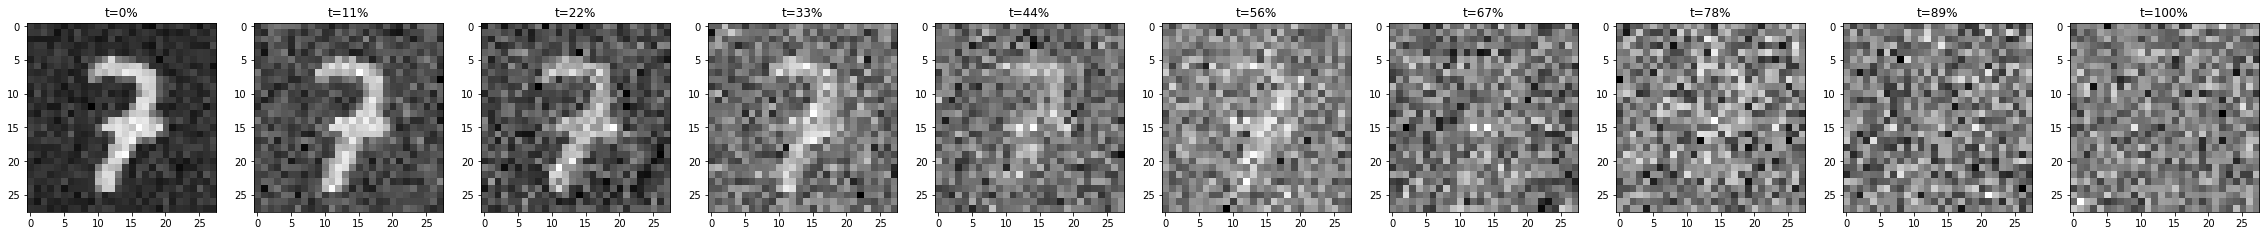

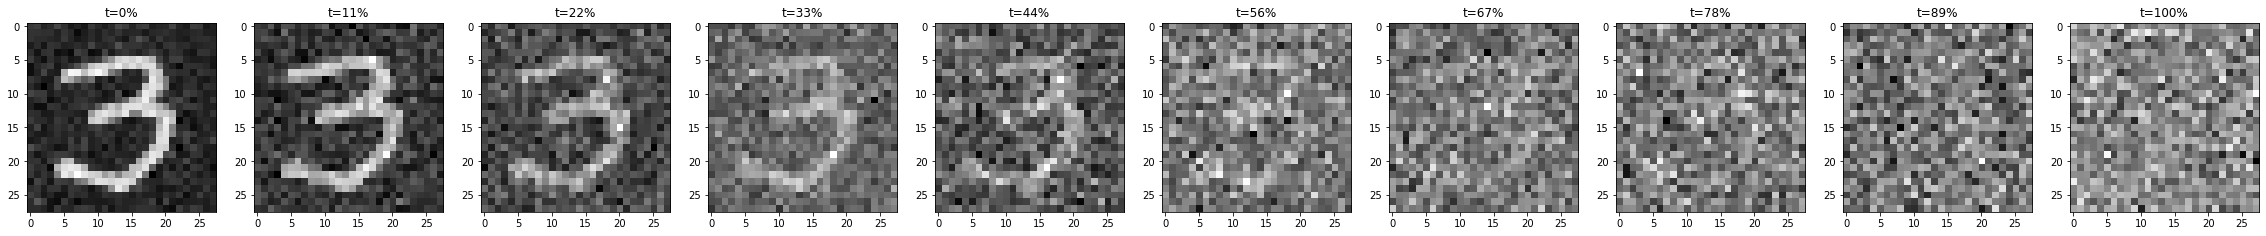

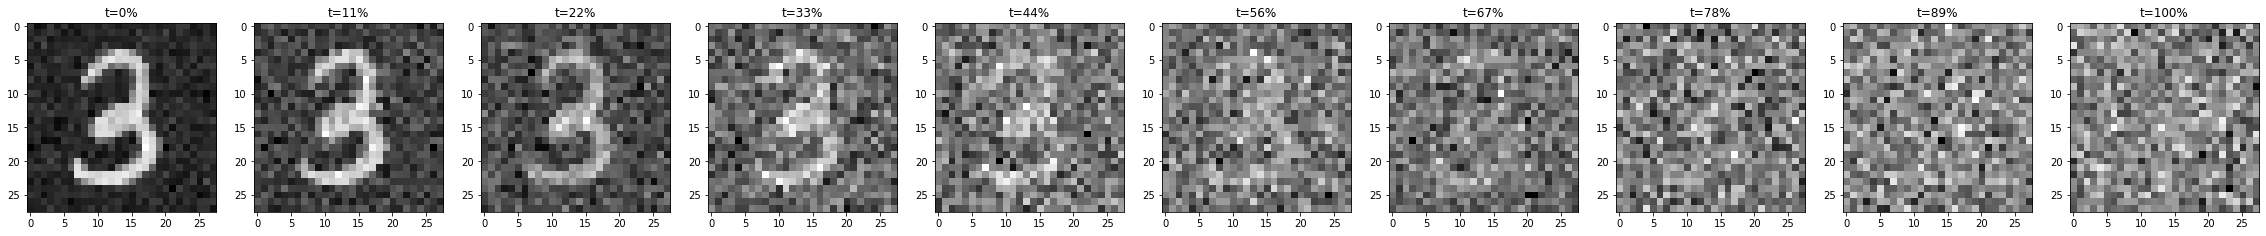

In [15]:
NB_DISPLAYED = 10
NB_EXAMPLES = 3

xs = dataset[:NB_EXAMPLES]
xs = forward_module.loop_forward(xs, nb_displayed_steps=NB_DISPLAYED)
xs = rearrange(xs, "t n h w -> n t h w")
for x in xs:
    plot_evolutions(x)

## Train the noise model

  0%|                                                                                            | 0/1000 [00:00<?, ?it/s]

loss=0.9985914975404739


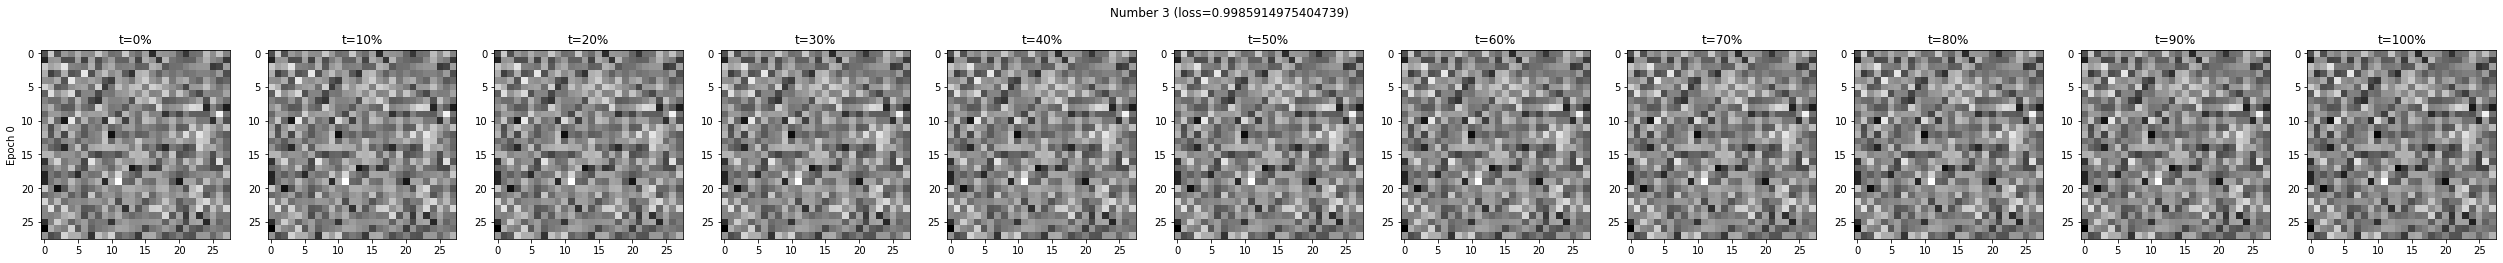

 10%|████████▏                                                                         | 100/1000 [00:13<02:01,  7.39it/s]

loss=0.06656759232282639


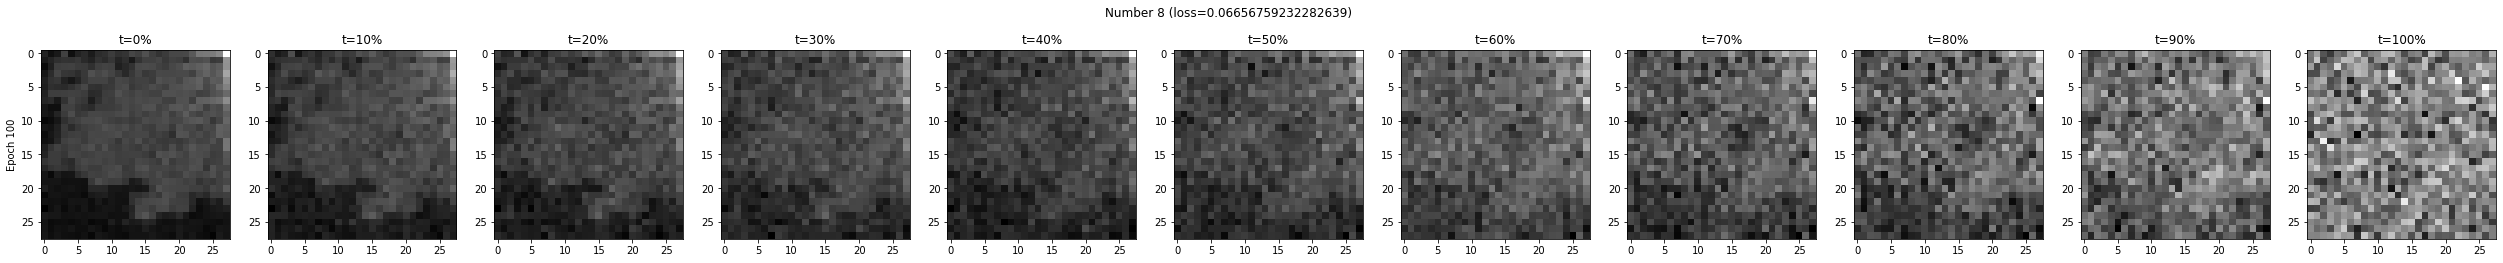

 20%|████████████████▎                                                                 | 199/1000 [00:24<01:02, 12.75it/s]

loss=0.05419129133224487


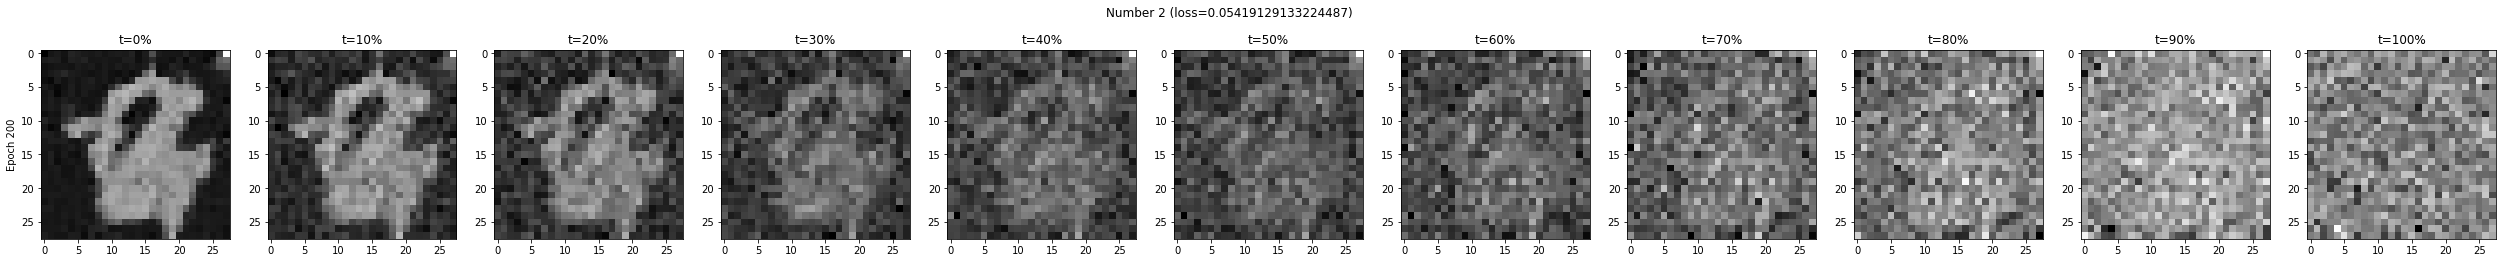

 30%|████████████████████████▌                                                         | 300/1000 [00:37<01:33,  7.52it/s]

loss=0.053174939006567


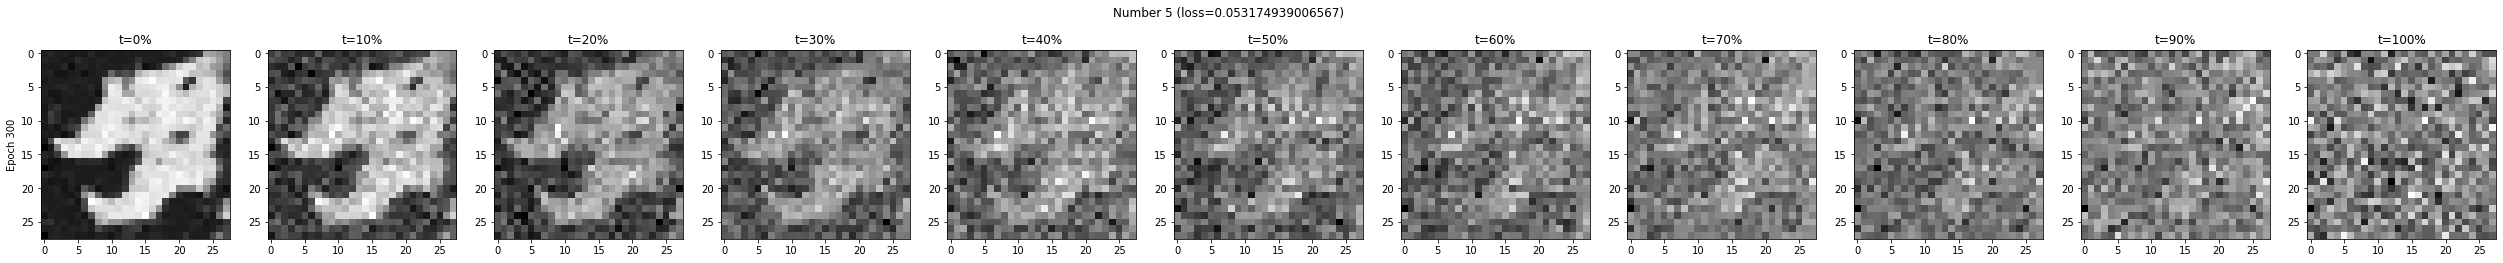

 40%|████████████████████████████████▊                                                 | 400/1000 [00:51<00:56, 10.56it/s]

loss=0.047917463816702366


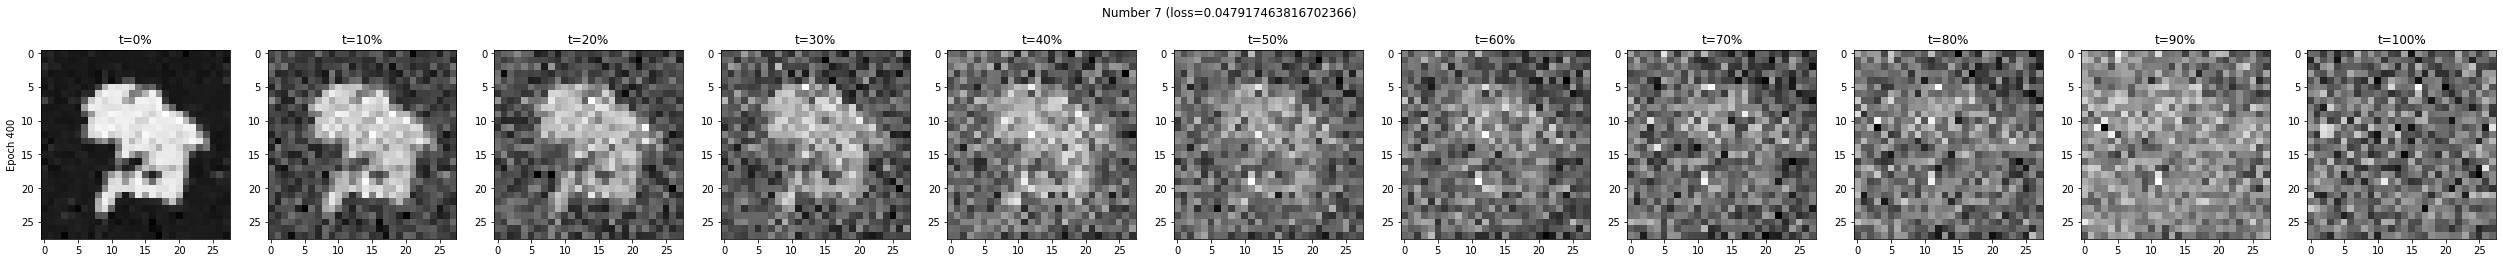

 50%|█████████████████████████████████████████                                         | 500/1000 [01:00<00:40, 12.49it/s]

loss=0.04898551292717457


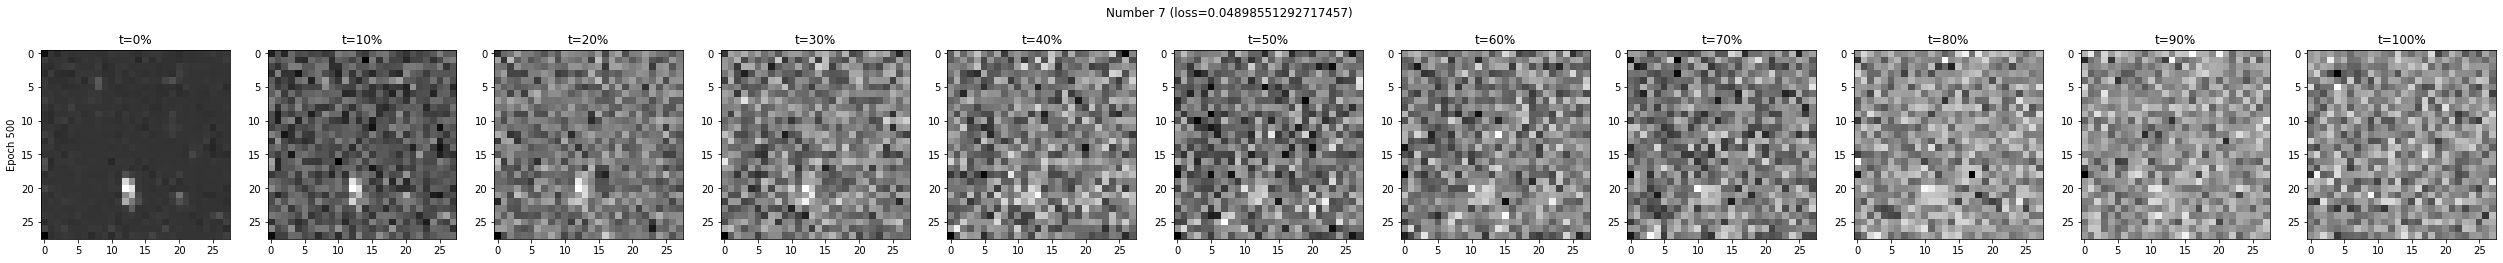

 60%|█████████████████████████████████████████████████                                 | 599/1000 [01:13<00:28, 13.97it/s]

loss=0.04361355118453503


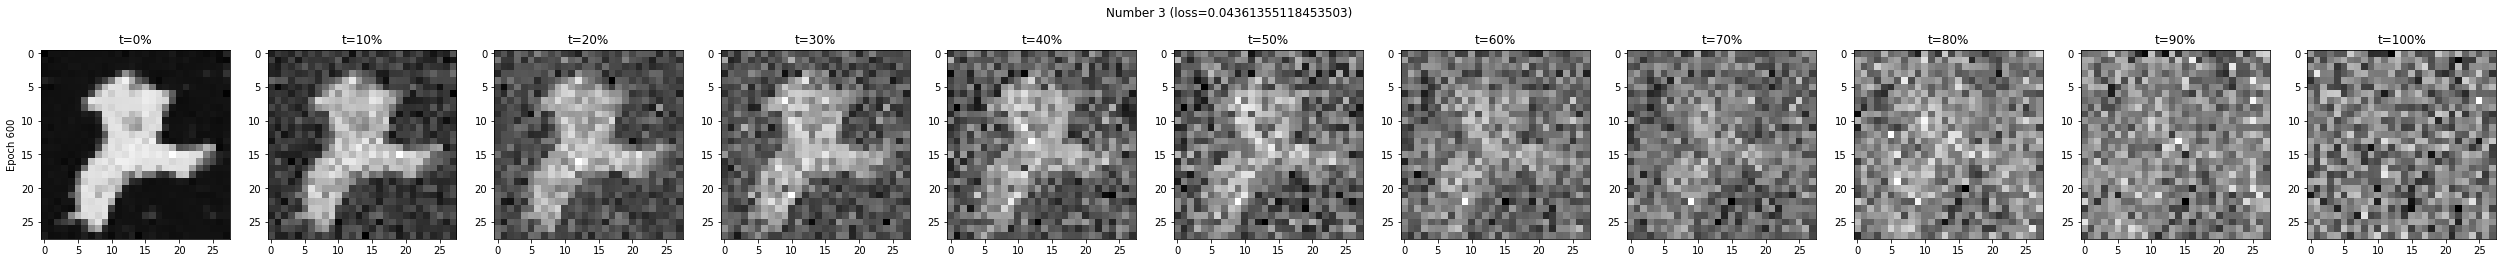

 70%|█████████████████████████████████████████████████████████▎                        | 699/1000 [01:21<00:20, 14.99it/s]

loss=0.043883128091692924


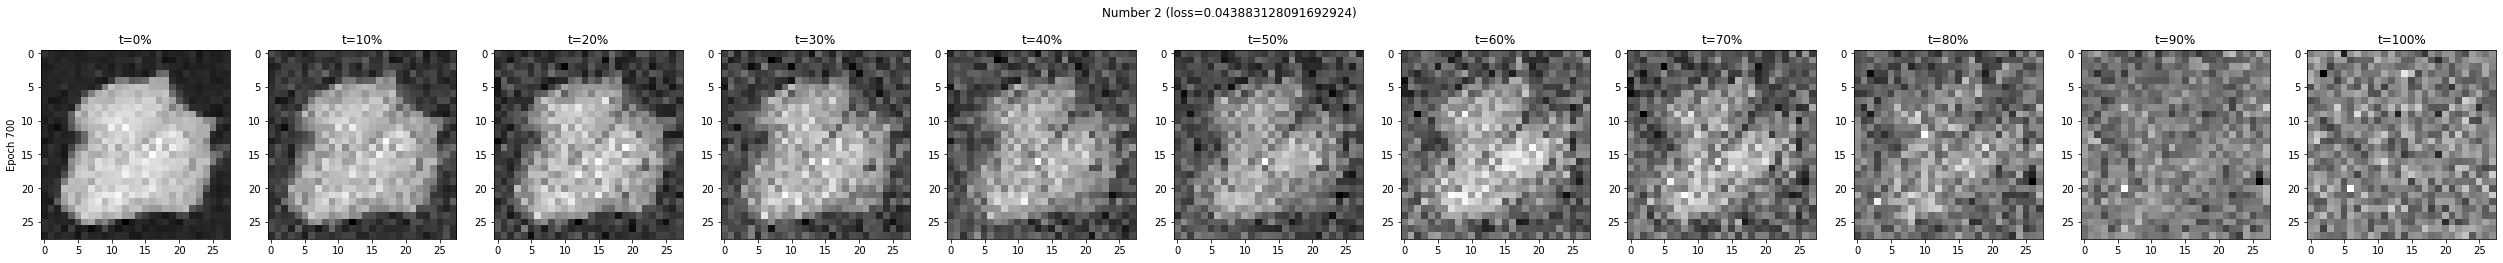

 80%|█████████████████████████████████████████████████████████████████▌                | 799/1000 [01:29<00:14, 14.04it/s]

loss=0.04179643373936415


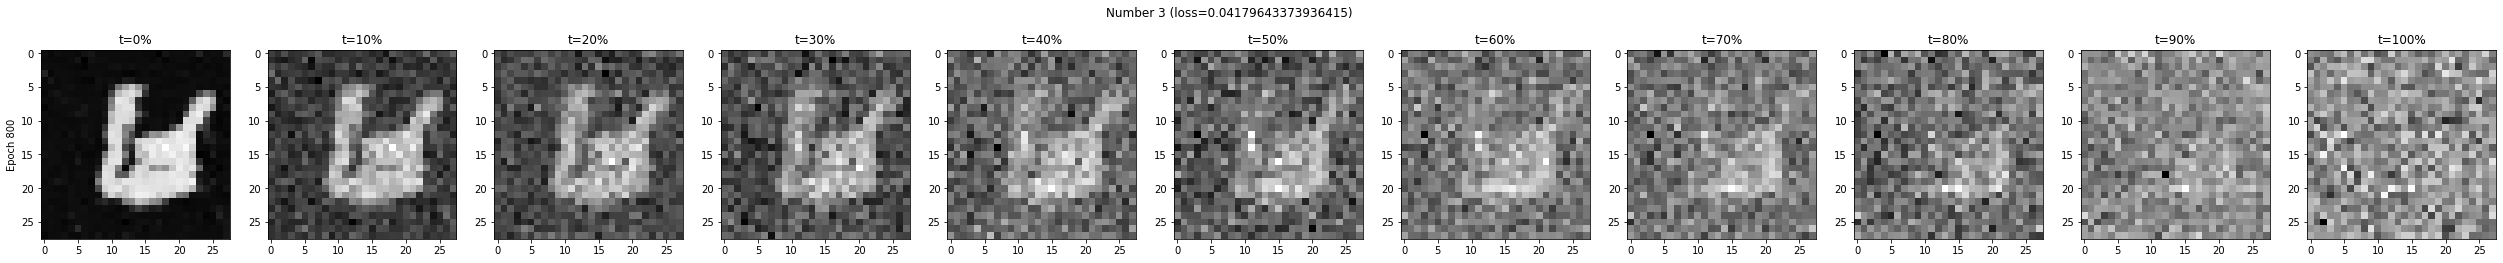

 90%|█████████████████████████████████████████████████████████████████████████▊        | 900/1000 [01:42<00:07, 13.37it/s]

loss=0.04019286576658487


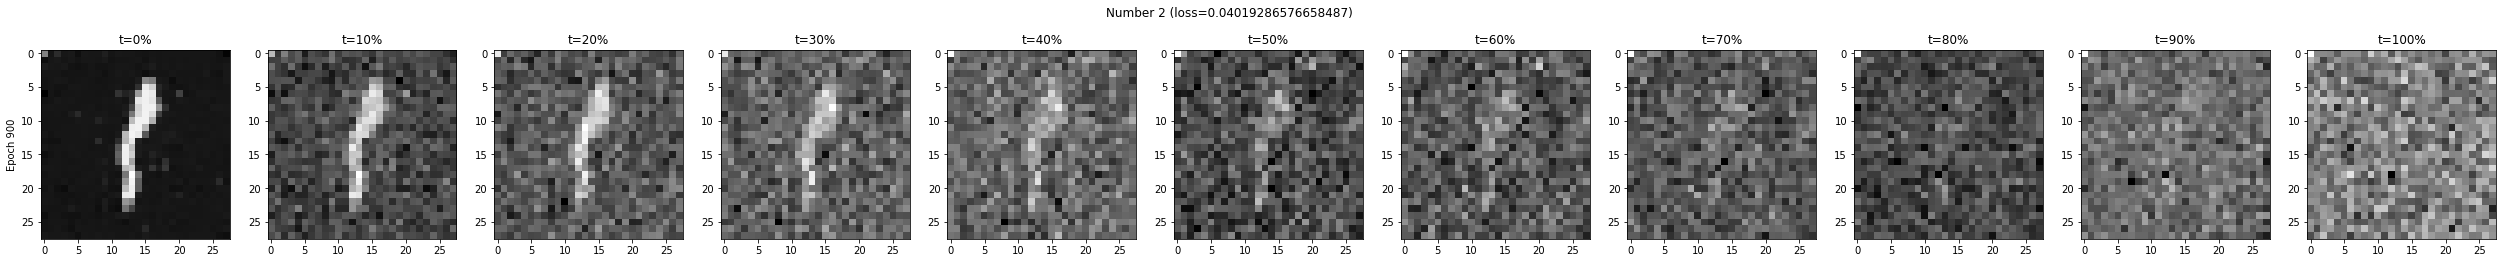

100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:50<00:00,  9.06it/s]


loss=None


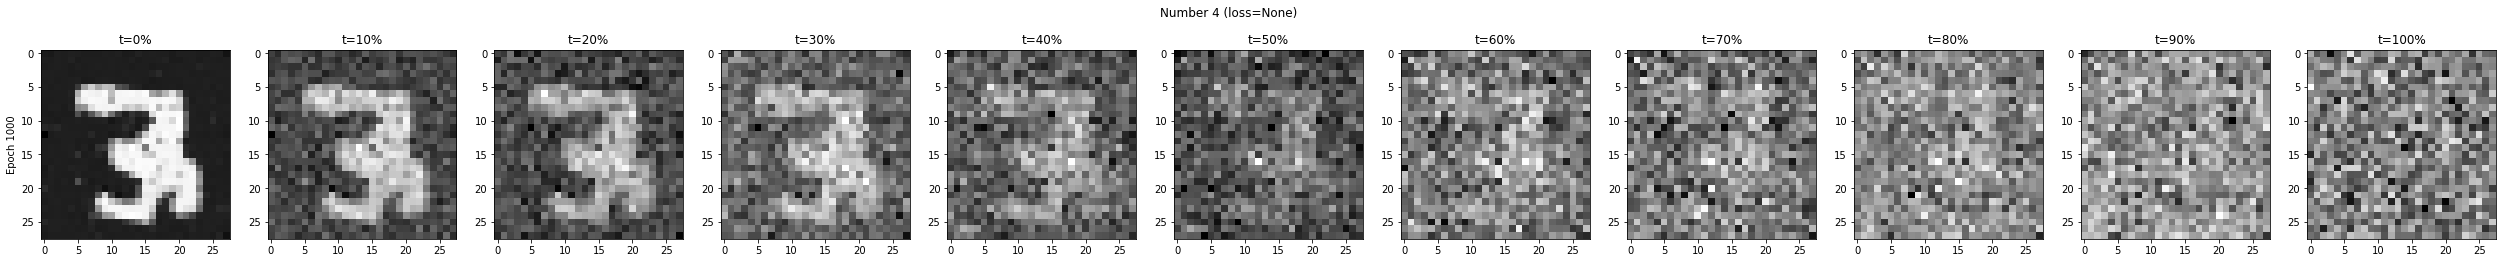

In [71]:
BATCH_SIZE = 256
NB_EPOCHS = 1000

def display_evolutions(epoch, losses=None):
    loss = sum(losses) / len(losses) if losses else None
    label = torch.randint(0, 10, (1,)).to(device)
    xs_t = backward_module.loop_backward(label, n_sample=1, nb_displayed_steps=NB_DISPLAYED)
    x_t = rearrange(xs_t, "t 1 h w -> t h w")
    print(f"loss={loss}")
    plot_evolutions(x_t, title=f"Number {label.item()} (loss={loss})", y_title=f"Epoch {epoch}")

X = TensorDataset(dataset, labels)
dataloader = DataLoader(X, batch_size=BATCH_SIZE)
noise_model.fit(dataloader, nb_epochs=NB_EPOCHS, logger=display_evolutions)
display_evolutions(NB_EPOCHS)

# Evaluation

In [74]:
def one_hot_encode(x, size):
    x = x.long()
    x = torch.zeros(x.size(0), size).to(device).scatter_(1, x, 1)
    return x

one_hot_encode(torch.tensor([[0], [2], [1]]).to(device), 3)

tensor([[1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

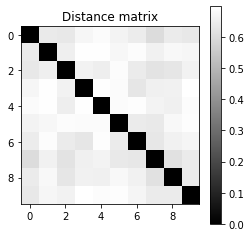

In [72]:
check_embedding(torch.eye(10), noise_model.label_embedding)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/lamsade/lmarandat/.local/lib/python3.9/site-packages/einops/einops.py", line 413, in reduce
    return _apply_recipe(recipe, tensor, reduction_type=reduction)
  File "/home/lamsade/lmarandat/.local/lib/python3.9/site-packages/einops/einops.py", line 236, in _apply_recipe
    _reconstruct_from_shape(recipe, backend.shape(tensor))
  File "/home/lamsade/lmarandat/.local/lib/python3.9/site-packages/einops/einops.py", line 166, in _reconstruct_from_shape_uncached
    raise EinopsError('Expected {} dimensions, got {}'.format(len(self.input_composite_axes), len(shape)))
einops.EinopsError: Expected 1 dimensions, got 0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/lamsade/lmarandat/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1031298/2434075868.py", l

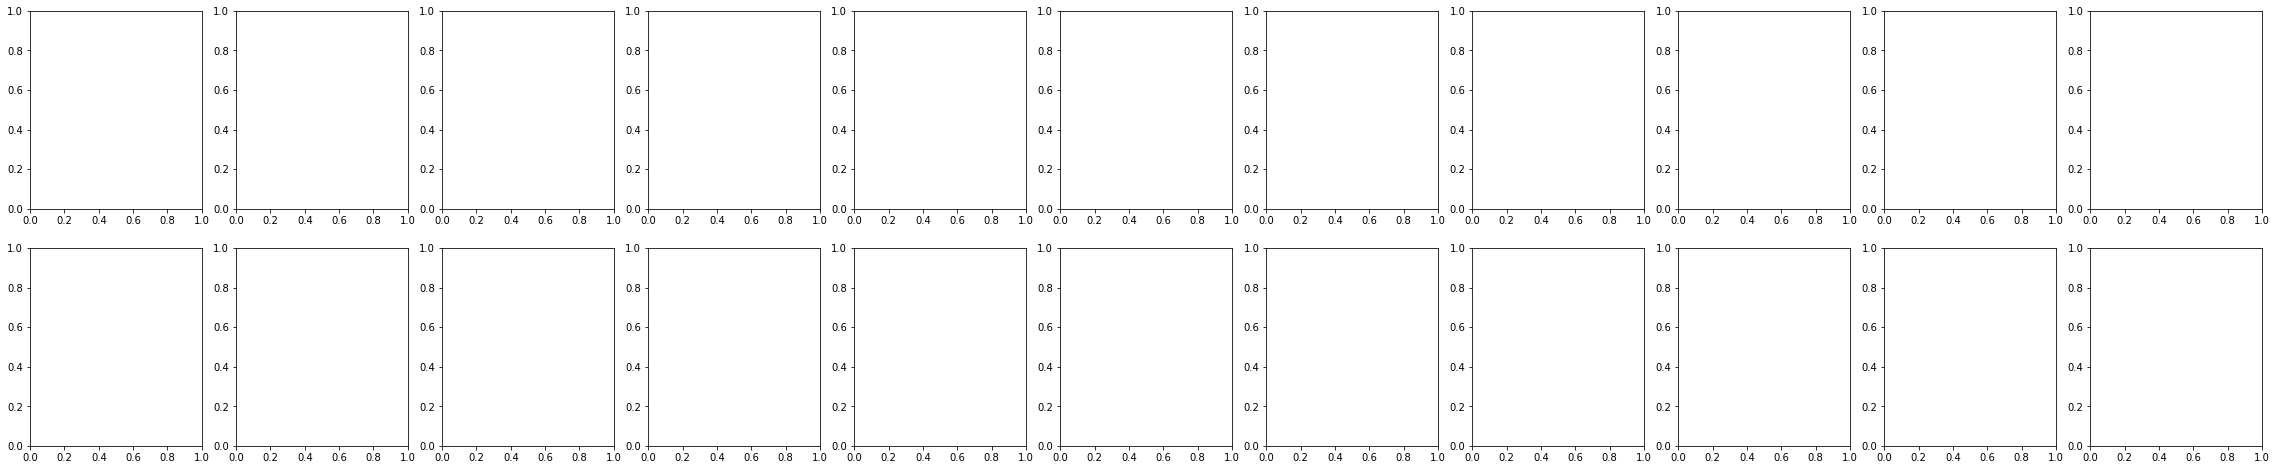

In [58]:
fig, axes = plt.subplots(2, T+1, figsize=(FIG_SIZE*T, FIG_SIZE*2))

x = dataset[0]
x_t = forward_module.loop_forward(x, nb_displayed_steps=T)
x_prev = [backward_module.batched_backward(x, t, labels[0]) for t, x in enumerate(x_t)]

x_t = rearrange(x_t, "t 1 h w -> t h w")
x_prev = rearrange(x_prev, "t 1 h w -> t h w")
x = rearrange(x, "1 h w -> h w")

axes[0, 0].imshow(x.cpu(), cmap='gray')
axes[1, -1].axis('off')
for i, ax in enumerate(axes[0, 1:]):
    ax.imshow(x_t[i].cpu(), cmap='gray')
for i, ax in enumerate(axes[1,:-1]):
    ax.imshow(x_prev[i].detach().cpu(), cmap='gray')

## Backward

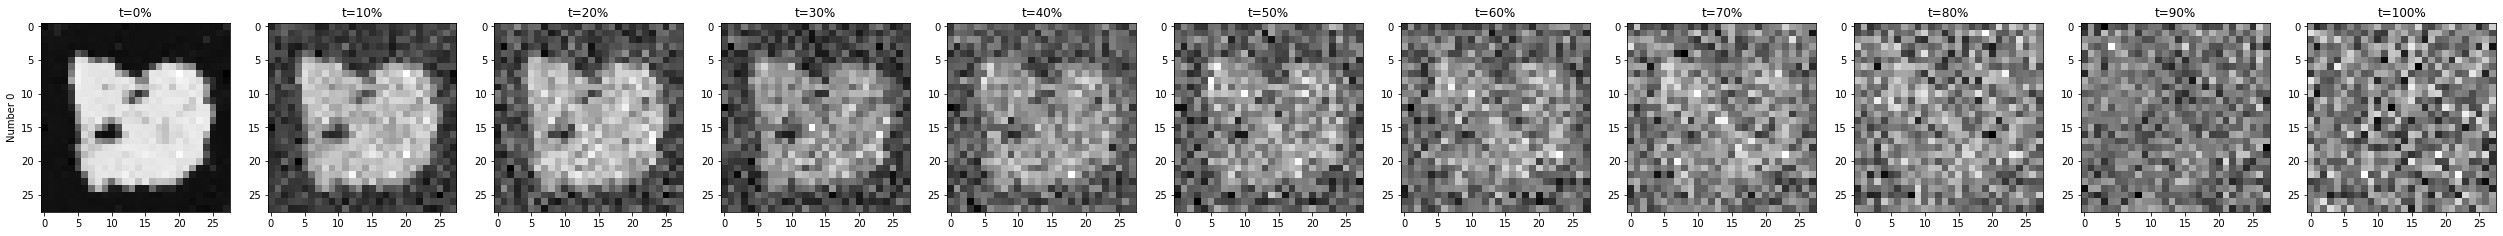

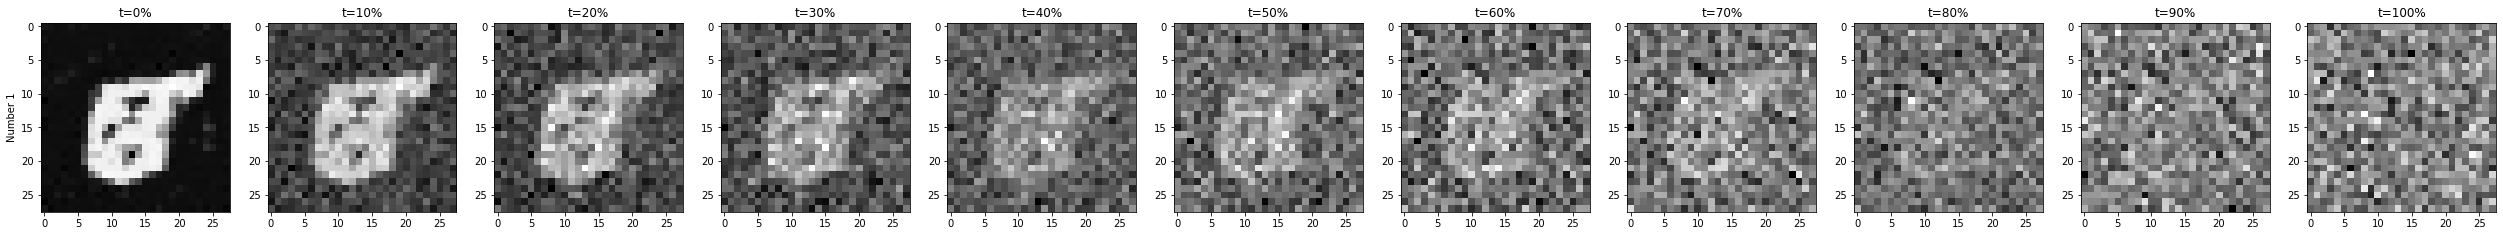

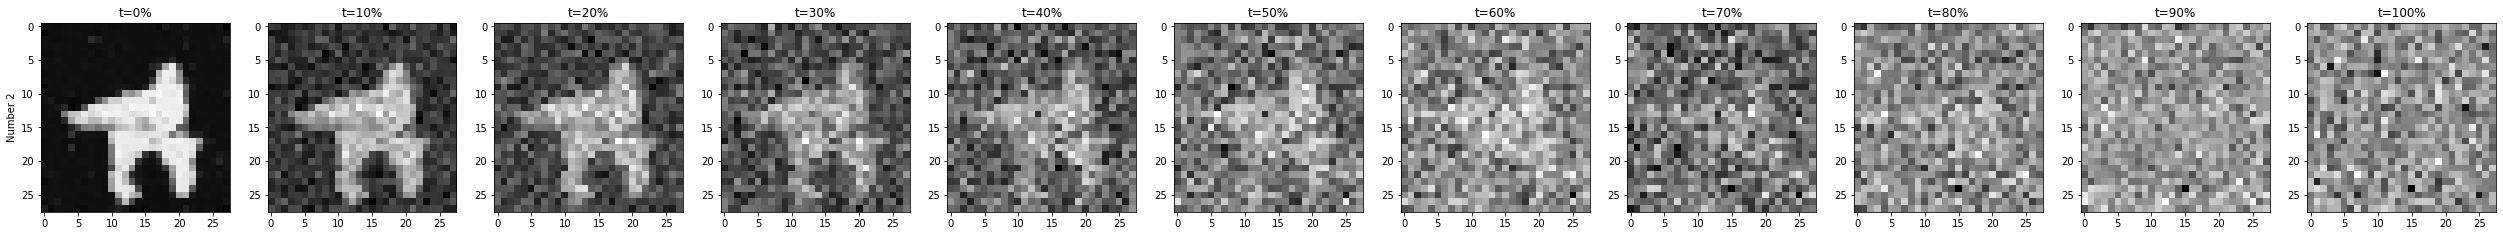

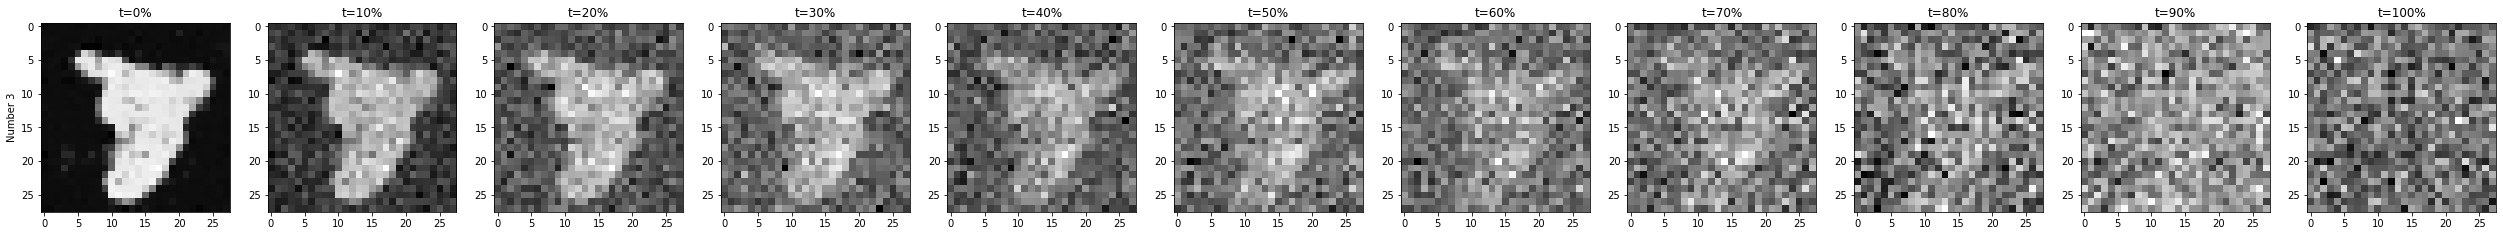

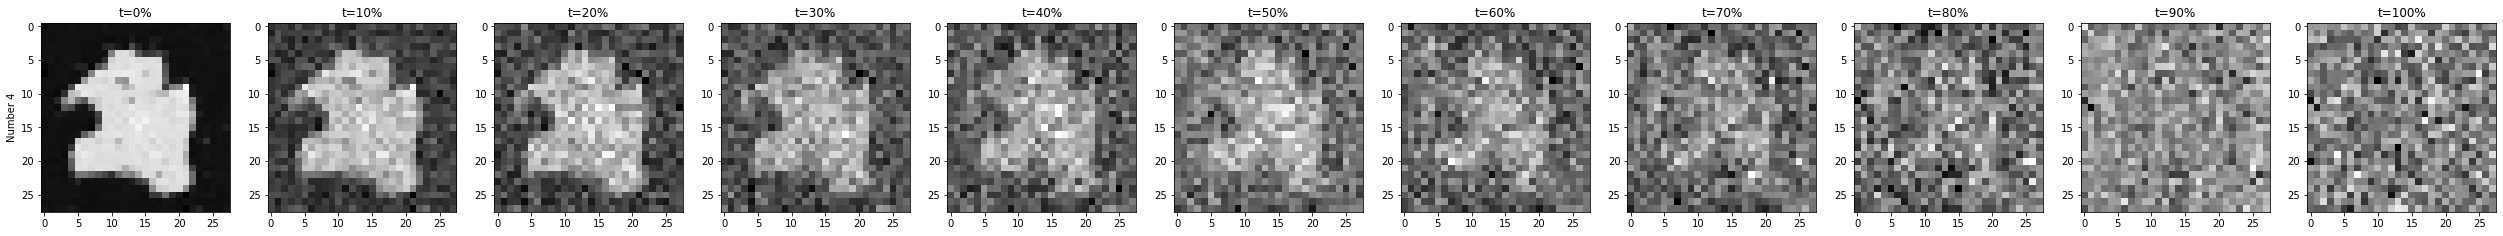

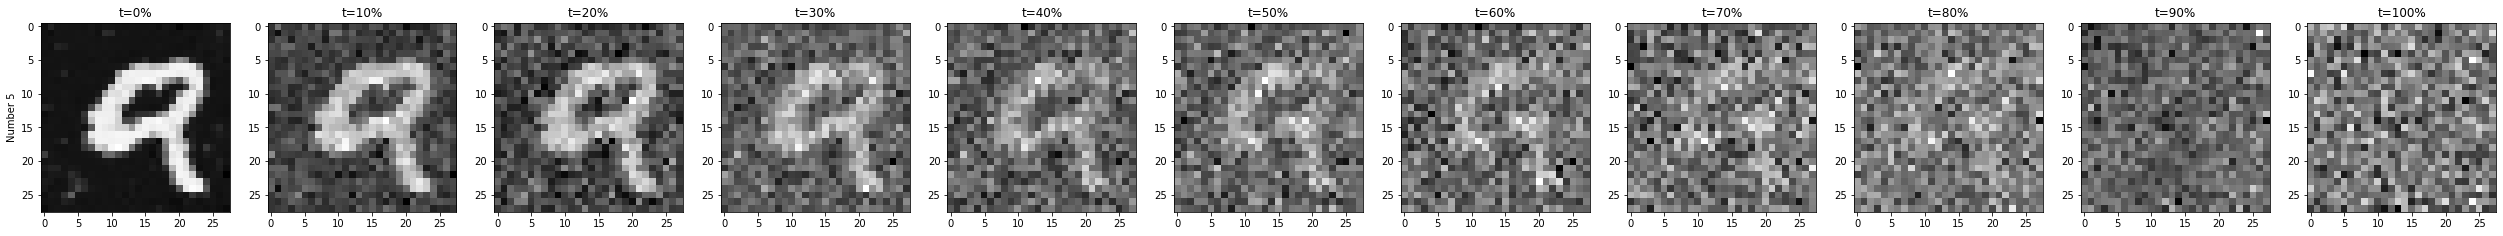

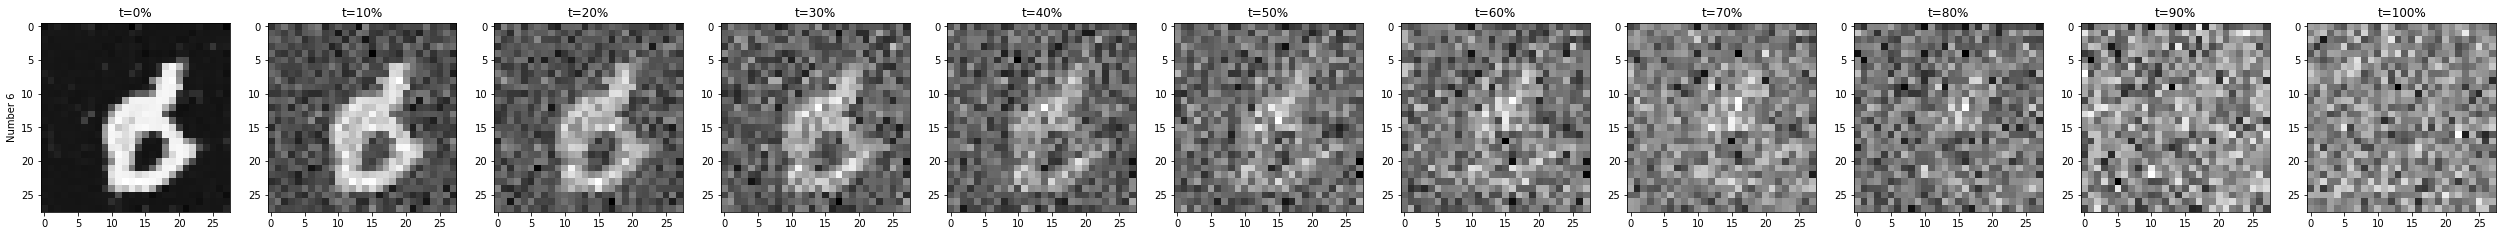

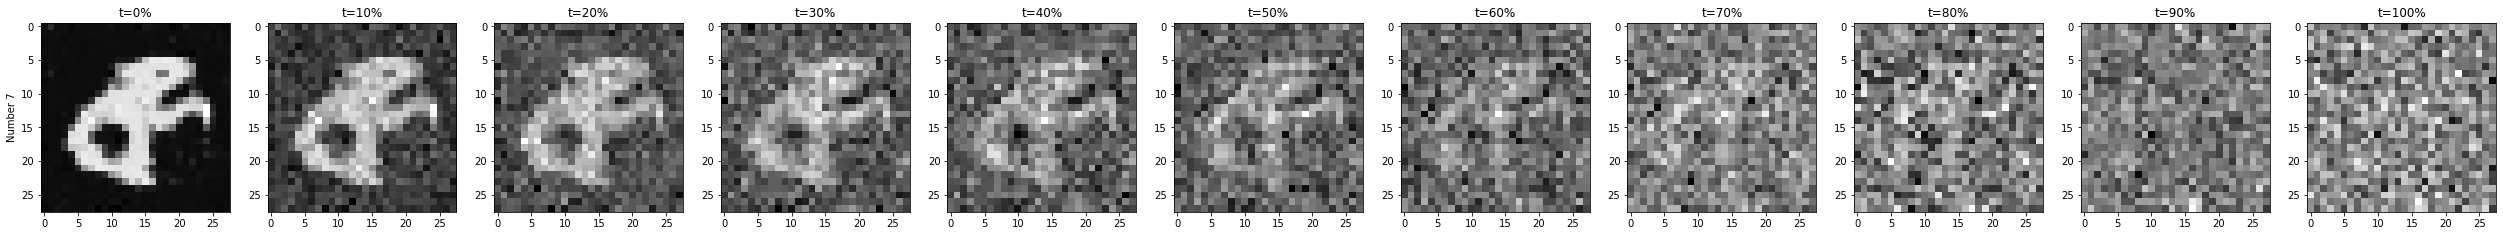

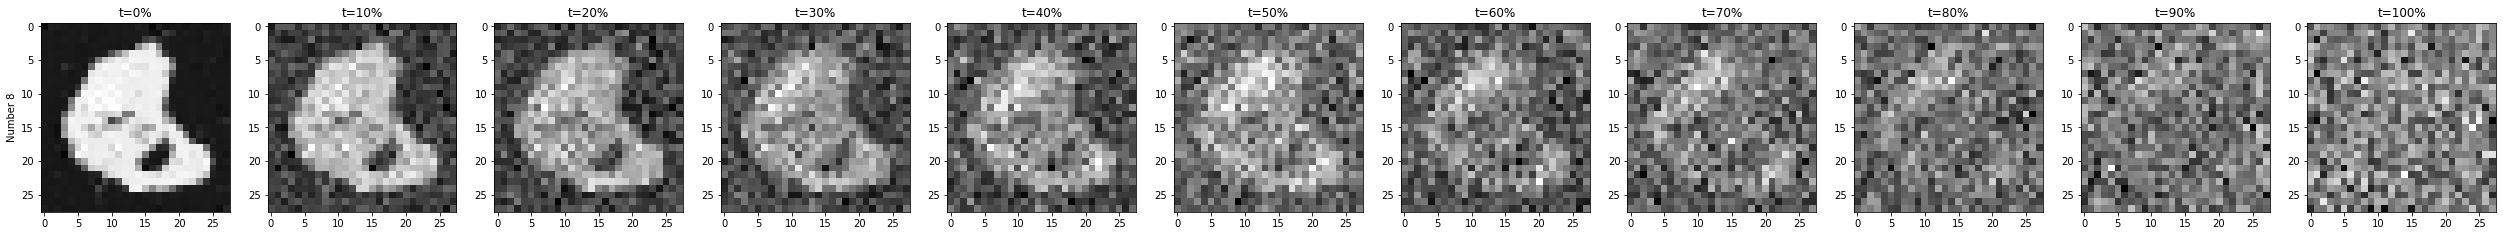

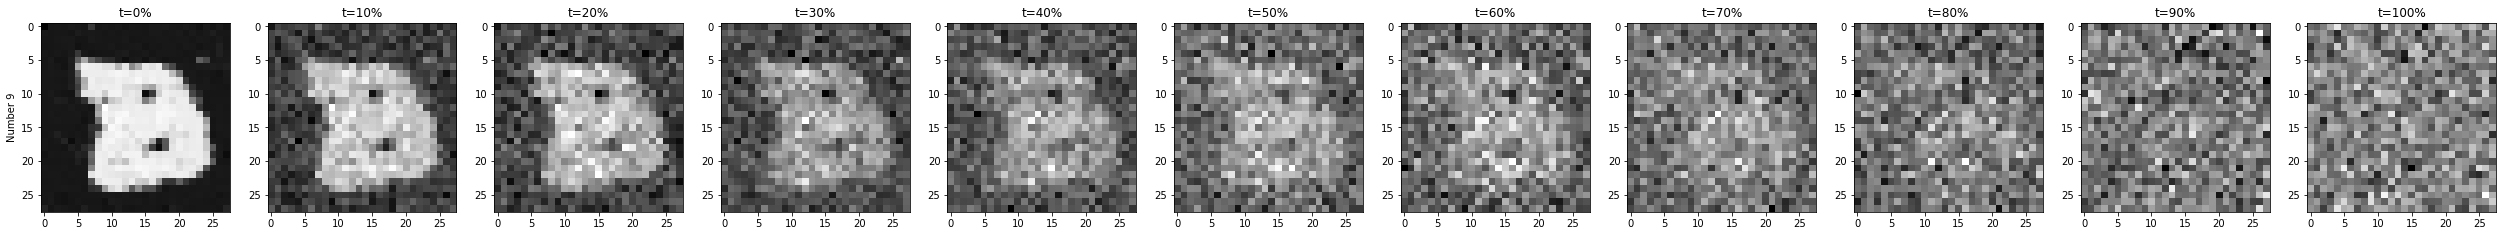

In [75]:
example_labels = torch.arange(0, 10).to(device)
# example_labels = torch.cat([label_vec for _, label_vec in example_labels], dim=0).to(device)

xs = backward_module.loop_backward(example_labels, n_sample=10, nb_displayed_steps=NB_DISPLAYED)
xs = rearrange(xs, "t n h w -> n t h w")
for i, x in enumerate(xs):
    plot_evolutions(x, y_title=f"Number {i}")